In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

Generating from folder  sink/plates_cups_and_bowls/plates
sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado'>
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise'>
Generating from folder  sink/plates_cups_and_bowls/cups
sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue :  <class '

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Meshcat url:  http://127.0.0.1:7000/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Convert dataset to observed node sets (caching output) and draw a few examples.

RECONVERT_DATASET = True
DATASET_YAML_FILE = "sink/saved_scenes.yaml"
DATASET_SAVE_FILE = "observed_node_sets.dat"

if RECONVERT_DATASET or not os.path.exists(DATASET_SAVE_FILE):
    type_map = {
        "bin": DishBin
    }
    model_map = {
    }
    for model_type_set in [PlateModels, CupModels, BowlModels]:
        for model_type in model_type_set:
            # Have to cut off the "sink" folder to match model names;
            # dataset management is ugly and should get reorganized...
            model_map[os.path.join(*model_type.sdf.split("/")[1:])] = model_type
    observed_node_sets = convert_scenes_yaml_to_observed_nodes(DATASET_YAML_FILE, type_map, model_map)
    print("Saving...")
    with open(DATASET_SAVE_FILE, "wb") as f:
        pickle.dump(observed_node_sets, f)

print("Loading...")
with open(DATASET_SAVE_FILE, "rb") as f:
    observed_node_sets = pickle.load(f)

draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(observed_node_sets[0]),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

[2021-09-30 20:02:00.913] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Saving...
Loading...


In [4]:
total_of_each_type = {"DishBin": 0}
for model_type_set in [PlateModels, CupModels, BowlModels]:
    for model_type in model_type_set:
        total_of_each_type[model_type.__name__] = 0
for observed_nodes in observed_node_sets:
    for node in observed_nodes:
        total_of_each_type[type(node).__name__] += 1
print(total_of_each_type)

{'DishBin': 30, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 12, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 12, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 21, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise': 0, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 12, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 12, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 14, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 9, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 10, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 8}


In [5]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

vis["sample"].delete()
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/structure")

In [6]:
observed_node_set_test = [
    BowlModels[0](drake_tf_to_torch_tf(RigidTransform(
        p=[0.5, 0.0, 0.1],
        R=UniformlyRandomRotationMatrix(RandomGenerator(0))))
    ),
    DishBin(drake_tf_to_torch_tf(
        RigidTransform(p=[0.5, 0., 0.]))
    )
]
print([type(node).__name__ for node in observed_node_set_test])

['sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl', 'DishBin']


In [7]:
supertree = grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

Supertree size  202


In [8]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
trees = get_optimized_trees_from_mip_results(infer_mle_tree_with_mip(grammar, observed_node_sets[0], N_solutions=5, max_recursion_depth=10, verbose=True))
vis["parses"].delete()
for k, tree in enumerate(trees):
    #draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k)

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  0.4711477756500244
Num vars:  3015
Num constraints:  6479
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Sep 30 20:02:02 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 4322 rows, 3015 columns and 17994 nonzeros
Model fingerprint: 0x8a9393ba
Model has 213 quadratic objective terms
Variable types: 2754 continuous, 261 integer (261 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+04]
  Objective range  [2e-01, 6e+01]
  QObjective range [2e+01, 3e+03]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e+00, 1e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3522 rows and 2355 columns
Presolve time: 0.03s
Presolved: 800 rows, 660 columns, 3460 nonzeros
Presolved model has 132 quadratic objective terms
Variable types: 645 continuous, 15

child tf:  tensor([[ 0.4957,  0.7976, -0.6617,  0.5000],
        [-1.0632,  1.5043,  0.9525,  0.0000],
        [-1.1518, -0.3175,  1.0000,  0.0100],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
FullBowl_3:Bowl_22 (active 0.0): child 0.000000
child tf:  tensor([[ 0.4957,  0.7976, -0.6617,  0.5000],
        [-1.0632,  1.5043,  0.9525,  0.0000],
        [-1.1518, -0.3175,  1.0000,  0.0100],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
FullBowl_3:BowlContents_4 (active 0.0): child 0.000000
FullBowl_4 (active 0.000000): child set score -inf
child tf:  tensor([[-1.7132,  0.7976, -0.6616,  0.5000],
        [ 0.2518,  1.5043,  0.9526,  0.0000],
        [ 0.0389, -0.3175,  1.0001,  0.0100],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
FullBowl_4:Bowl_23 (active 0.0): child 0.000000
child tf:  tensor([[-1.7132,  0.7976, -0.6616,  0.5000],
        [ 0.2518,  1.5043,  0.9526,  0.0000],
        [ 0.0389, -0.3175,  1.0001,  0.0100],
 

Plate_38:sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise_53 (active 0.0): child 0.000000
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5000],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_38:sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise_34 (active 0.0): child 0.000000
Bowl_29 (active 0.000000): child set score -inf
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5000],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_29:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_38 (active 0.0): child 0.000000
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5000],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,

child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5833],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_21:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_30 (active 0.0): child 0.000000
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5833],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_21:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue_30 (active 0.0): child 0.000000
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5833],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_21:sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose_28 (active 0.0): child 0.000000
PlateStack_4 

child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5000],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_28:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_37 (active 0.0): child 0.000000
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5000],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_28:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue_37 (active 0.0): child 0.000000
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5000],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_28:sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose_35 (active 0.0): child 0.000000
Cup_24 (activ

XYZ:  0.0
Rot:  0.0
Bowl_18:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue_27 (active 0.0): child 0.000000
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5833],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_18:sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose_25 (active 0.0): child 0.000000
Bowl_19 (active 0.000000): child set score -inf
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5833],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_19:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_28 (active 0.0): child 0.000000
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5833],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.

Rot:  0.0
Plate_35:sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise_31 (active 0.0): child 0.000000
Bowl_26 (active 0.000000): child set score -inf
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5000],
        [ 1.2488,  1.0690,  1.1934,  0.0000],
        [-0.2770,  1.2601,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_26:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_35 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5000],
        [ 1.2488,  1.0690,  1.1934,  0.0000],
        [-0.2770,  1.2601,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_26:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue_35 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5000],
        [ 1.2488,  1.0690,  1.1934,  0.0000],
        [-0.2770,  1.2601,  1.0002,  0.0300],
        [ 0.0000,

child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5000],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  -0.7632171892830317
Rot:  -2.3706711159518097
AssortedBowls_3:Bowl_19 (active 0.0): child -3.133888
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5000],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  -0.7632171892830317
Rot:  -2.3706711159518097
AssortedBowls_3:Bowl_20 (active 0.0): child -3.133888
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5000],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  -0.7632171892830317
Rot:  -2.3706711159518097
AssortedBowls_3:Bowl_21 (active 0.0): child -3.133888
AssortedPlateStacks_4 (active 1.000000): child set score -0.405465
child tf:  tensor([[ 1.0000

PlateStack_5:Plate_32 (active 0.0): child -580.091966
FullBowl_3 (active 1.000000): child set score 0.000000
child tf:  tensor([[-8.0968e-01,  5.8672e-01, -1.3639e-02,  5.8332e-01],
        [ 5.8661e-01,  8.0979e-01,  1.1058e-02,  1.6767e-01],
        [ 1.7530e-02,  9.5147e-04, -9.9984e-01,  1.6884e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
XYZ:  0.0
Rot:  0.0
FullBowl_3:Bowl_22 (active 1.0): child 0.000000
child tf:  tensor([[-8.0968e-01,  5.8672e-01, -1.3639e-02,  5.8332e-01],
        [ 5.8661e-01,  8.0979e-01,  1.1058e-02,  1.6767e-01],
        [ 1.7530e-02,  9.5147e-04, -9.9984e-01,  1.6884e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])
XYZ:  0.0
Rot:  0.0
FullBowl_3:BowlContents_4 (active 1.0): child 0.000000
FullBowl_4 (active 0.000000): child set score -inf
child tf:  tensor([[-1.7132,  0.7976, -0.6616,  0.5833],
        [ 0.2518,  1.5043,  0.9526,  0.0000],
        [ 0.0389, -0.3175,  1.0001,  0.0100],
        [ 0.0000,  0.0000,  

Plate_38:sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado_47 (active 0.0): child 0.000000
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5833],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_38:sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise_53 (active 0.0): child 0.000000
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5833],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_38:sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise_34 (active 0.0): child 0.000000
Bowl_29 (active 0.000000): child set score -inf
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5833],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
X

Rot:  0.0
Bowl_21:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_30 (active 0.0): child 0.000000
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5000],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_21:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue_30 (active 0.0): child 0.000000
child tf:  tensor([[-0.8096, -0.9614, -0.6616,  0.5000],
        [-1.4134, -1.1902,  0.9526,  0.0000],
        [ 0.3299,  0.2677,  1.0002,  0.0250],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_21:sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose_28 (active 0.0): child 0.000000
PlateStack_4 (active 1.000000): child set score 0.000000
child tf:  tensor([[ 0.8121, -0.5783, -0.0776,  0.4422],
        [ 0.5827,  0.8107,  0.0567, -0.2168],
        [ 0.0301, -0.0912,  0.9954,  0.0352],
        [ 0.0

child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5833],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_37:sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado_46 (active 0.0): child 0.000000
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5833],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_37:sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise_52 (active 0.0): child 0.000000
child tf:  tensor([[ 1.0691, -0.6944, -0.6616,  0.5833],
        [ 0.9836,  0.9307,  0.9526,  0.0000],
        [-0.2349,  0.9701,  1.0002,  0.0300],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_37:sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise_33 (active 0.0): child 0.000000
Bowl_28 (active 0.000000): ch

In [9]:
print(len(trees))

5


# MIPMAP-EM alternation

In [10]:
em = EMWrapper(grammar, observed_node_sets)
em.do_iterated_em_fitting(em_iterations=5, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=10)

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (AssortedBowls): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow): None
    (AssortedPlates): ConstrainedParameter()
    (PlateStack): None
    (FullBowl): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise): None
    (Bowl): ConstrainedParameter()
    (sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue): None
    (sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado): None
    (DishBin): ConstrainedParameter()
    (AssortedPlateStacks): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (AssortedCups): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue): None
    (Object): ConstrainedParameter()
    (Plate): ConstrainedParam

In [11]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar.torch")

Final params:  tensor([0.4995, 0.6987, 0.3724, 0.4000, 0.2993])


Final params:  tensor([0.0209, 0.5802, 0.3989])


Plate
Final params:  tensor([2.6664e-01, 2.6664e-01, 4.6662e-01, 9.9990e-05])


PlateStack
mean tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
0:xyz:mean final: tensor([0., 0., 0.])
variance tensor([[0.0050, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.0050],
        [0.0050, 0.0050, 0.0050]])
0:xyz:variance final: tensor([0.0050, 0.0050, 0.0050])
0:rot:M final: tensor([[6.1232e-17, 6.1232e-17, 6.1232e-17, 1.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]])
0:rot:Z final: tensor([-1.0000e+03, -1.0000e+03, -1.0000e-01,  0.0000e+00])
mean tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
1:xyz:mean final: tensor([0., 0., 0.])
variance tensor([[0.0050, 0.0050, 0.0050],

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:771: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


AssortedPlateStacks
Final params:  tensor([0.9999])
mean tensor([[ 0.0000,  0.0000,  0.0100],
        [-0.0129,  0.0208,  0.0147],
        [-0.0159,  0.0217,  0.0147],
        [-0.0165,  0.0218,  0.0147],
        [-0.0166,  0.0218,  0.0147],
        [-0.0166,  0.0218,  0.0147]])
0:xyz:mean final: tensor([-0.0166,  0.0218,  0.0147])
variance tensor([[5.0000e-02, 5.0000e-02, 1.0000e-03],
        [1.7419e-03, 2.2355e-02, 1.0000e-06],
        [2.2539e-04, 1.9939e-02, 1.0000e-06],
        [7.7533e-06, 1.9462e-02, 1.0000e-06],
        [1.0000e-06, 1.9356e-02, 1.0000e-06],
        [1.0000e-06, 1.9332e-02, 1.0000e-06]])
0:xyz:variance final: tensor([1.0000e-06, 1.9332e-02, 1.0000e-06])
AssortedFullBowls
Final params:  tensor([0.8998])
mean tensor([[ 0.0000,  0.0000,  0.0100],
        [-0.0364,  0.0564,  0.0202],
        [-0.0366,  0.0550,  0.0199],
        [-0.0366,  0.0549,  0.0199],
        [-0.0366,  0.0549,  0.0199],
        [-0.0366,  0.0549,  0.0199]])
0:xyz:mean final: tensor([-0.0366, 

/home/gizatt/projects/spatial_scene_grammars/spatial_scene_grammars/parameter_estimation.py:771: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


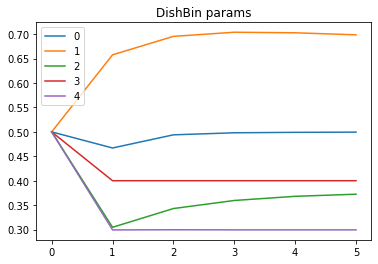

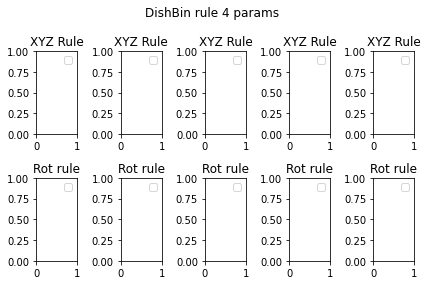

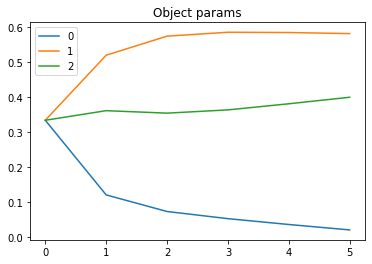

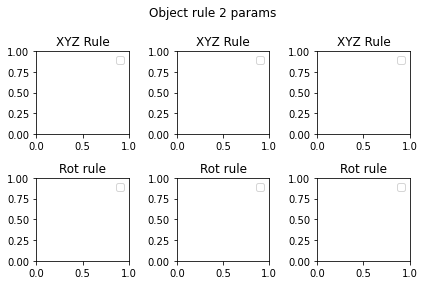

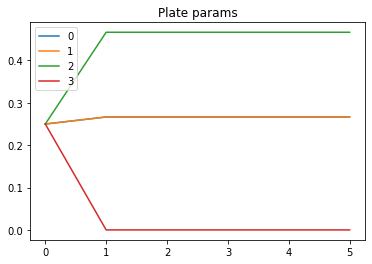

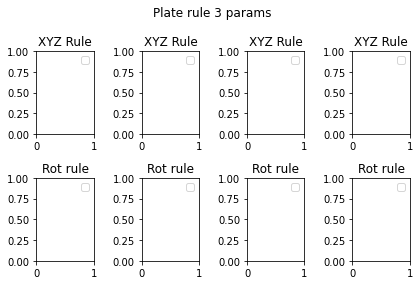

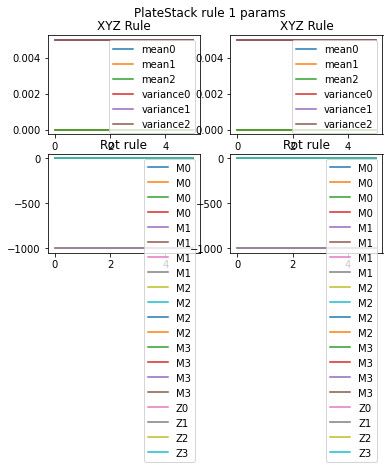

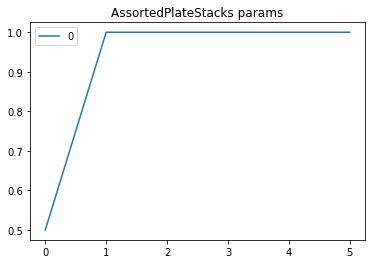

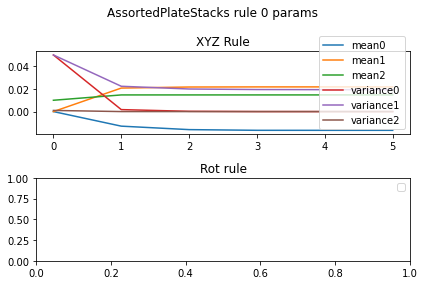

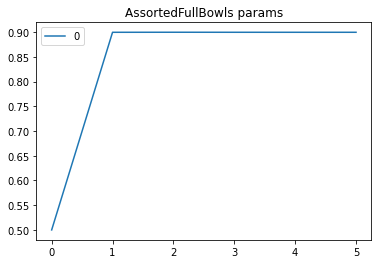

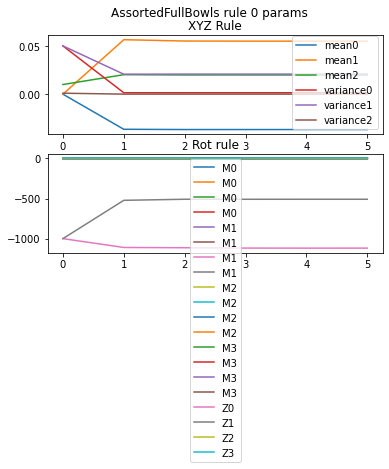

In [12]:
em.plot_grammar_parameter_history(DishBin)
em.plot_grammar_parameter_history(Object)
print("Plate")
em.plot_grammar_parameter_history(Plate)
print("PlateStack")
em.plot_grammar_parameter_history(PlateStack)
print("AssortedPlateStacks")
em.plot_grammar_parameter_history(AssortedPlateStacks)
print("AssortedFullBowls")
em.plot_grammar_parameter_history(AssortedFullBowls)

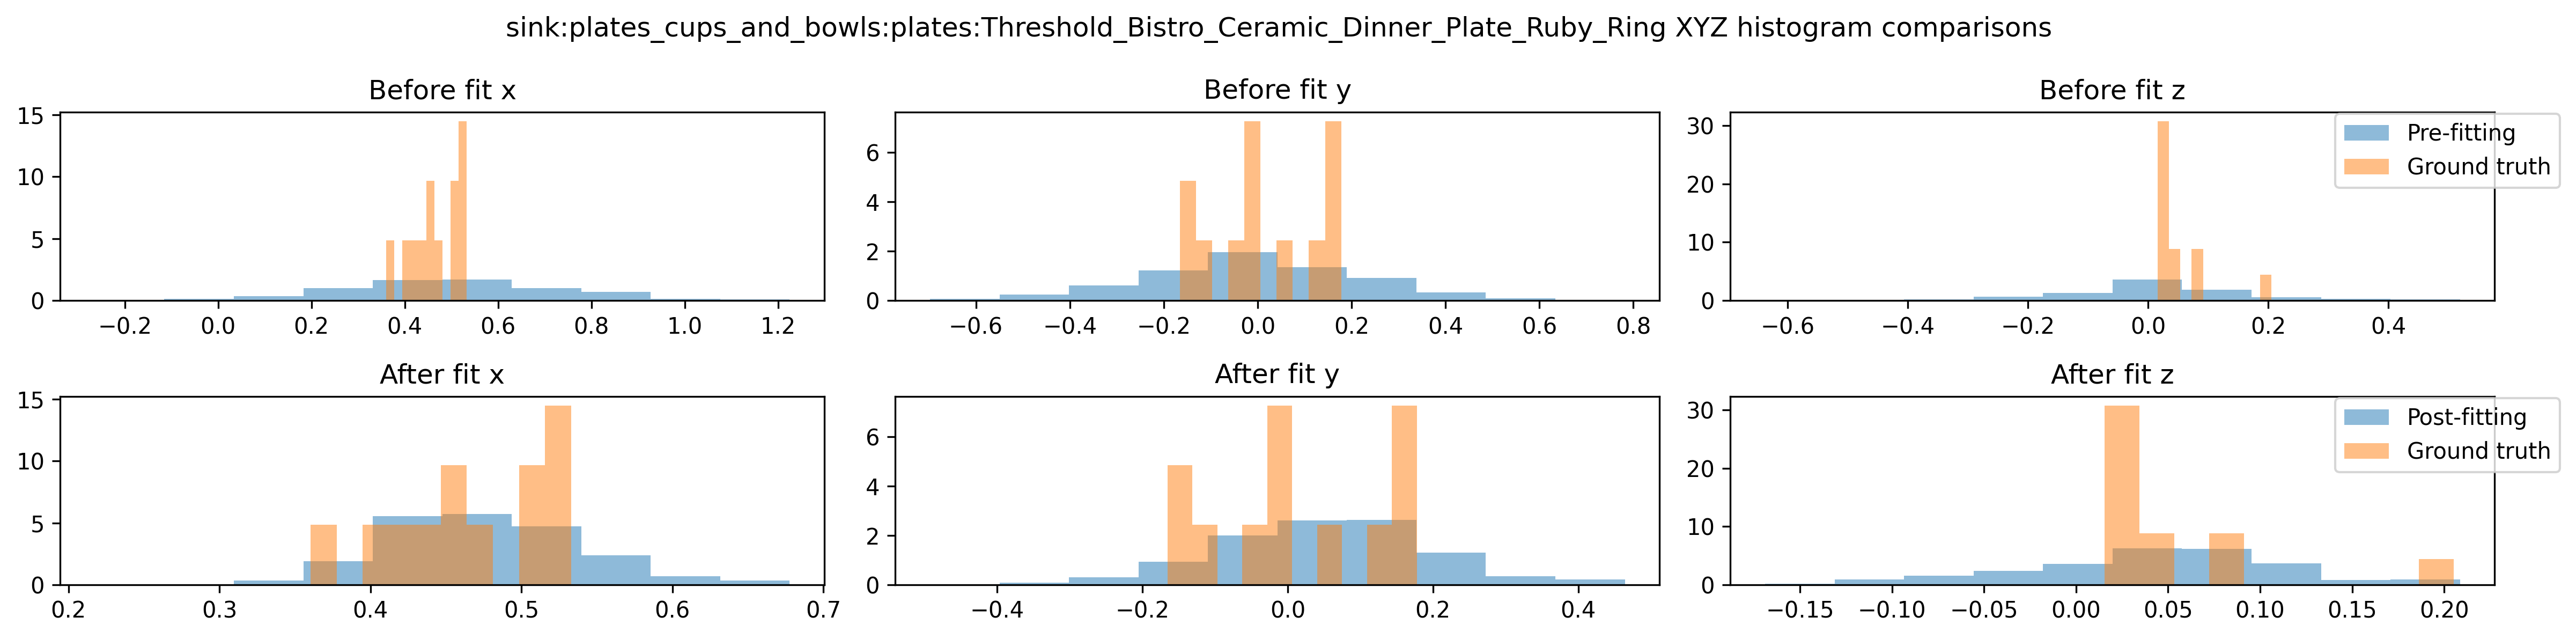

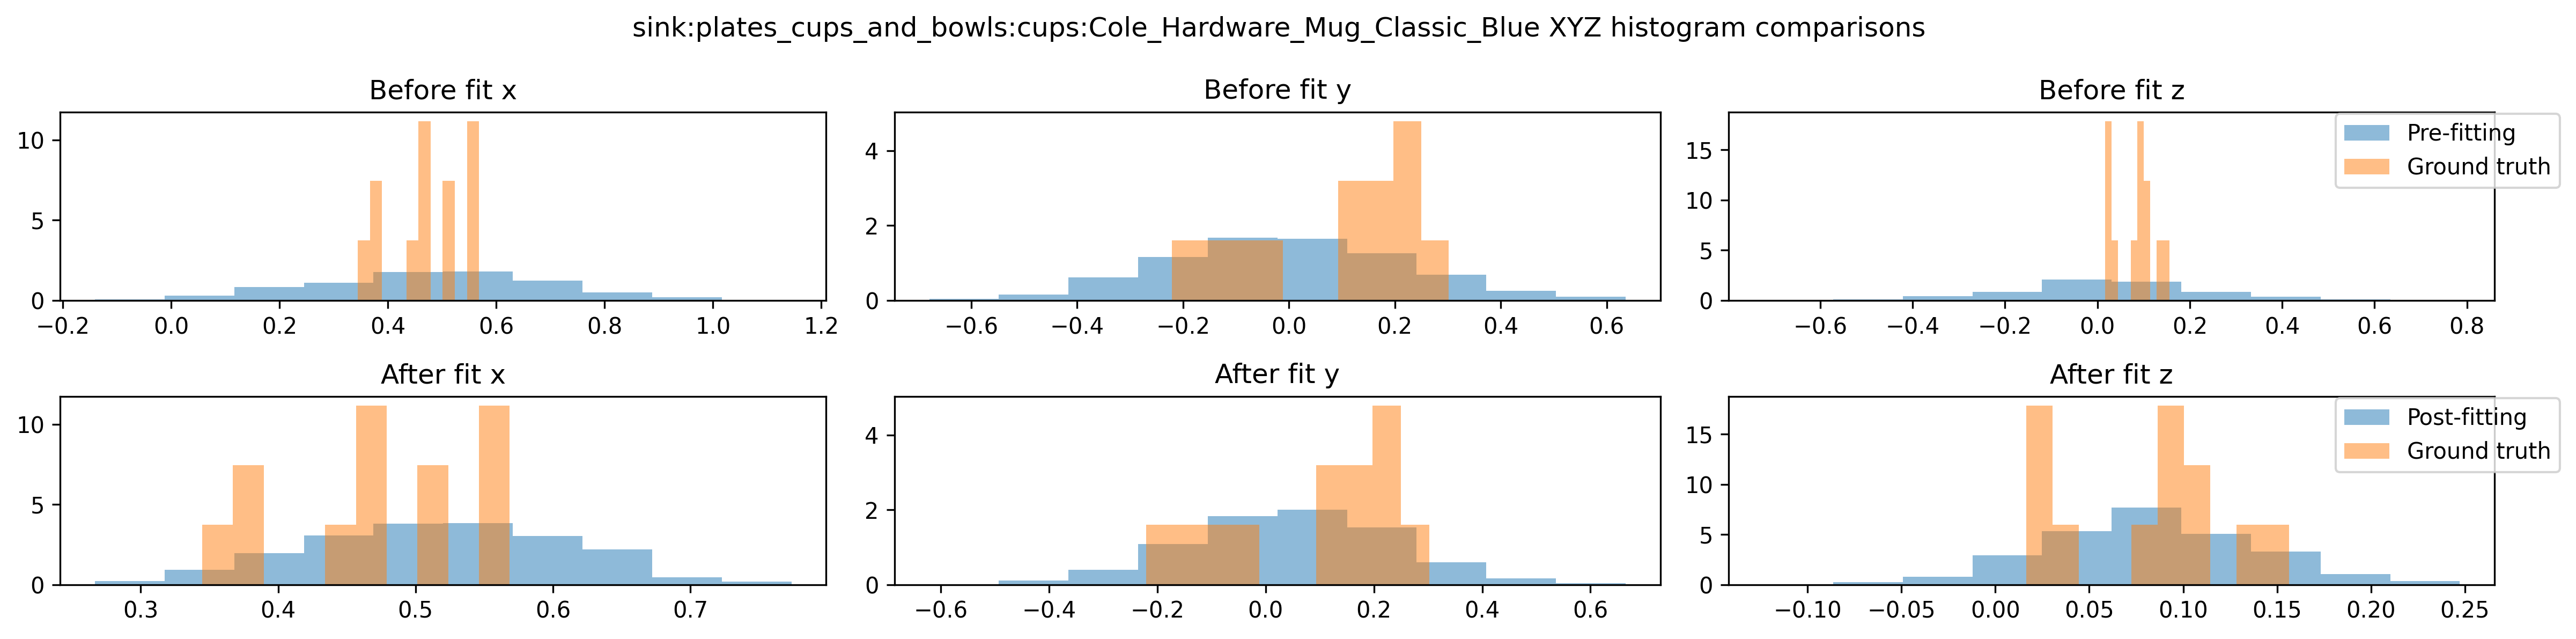

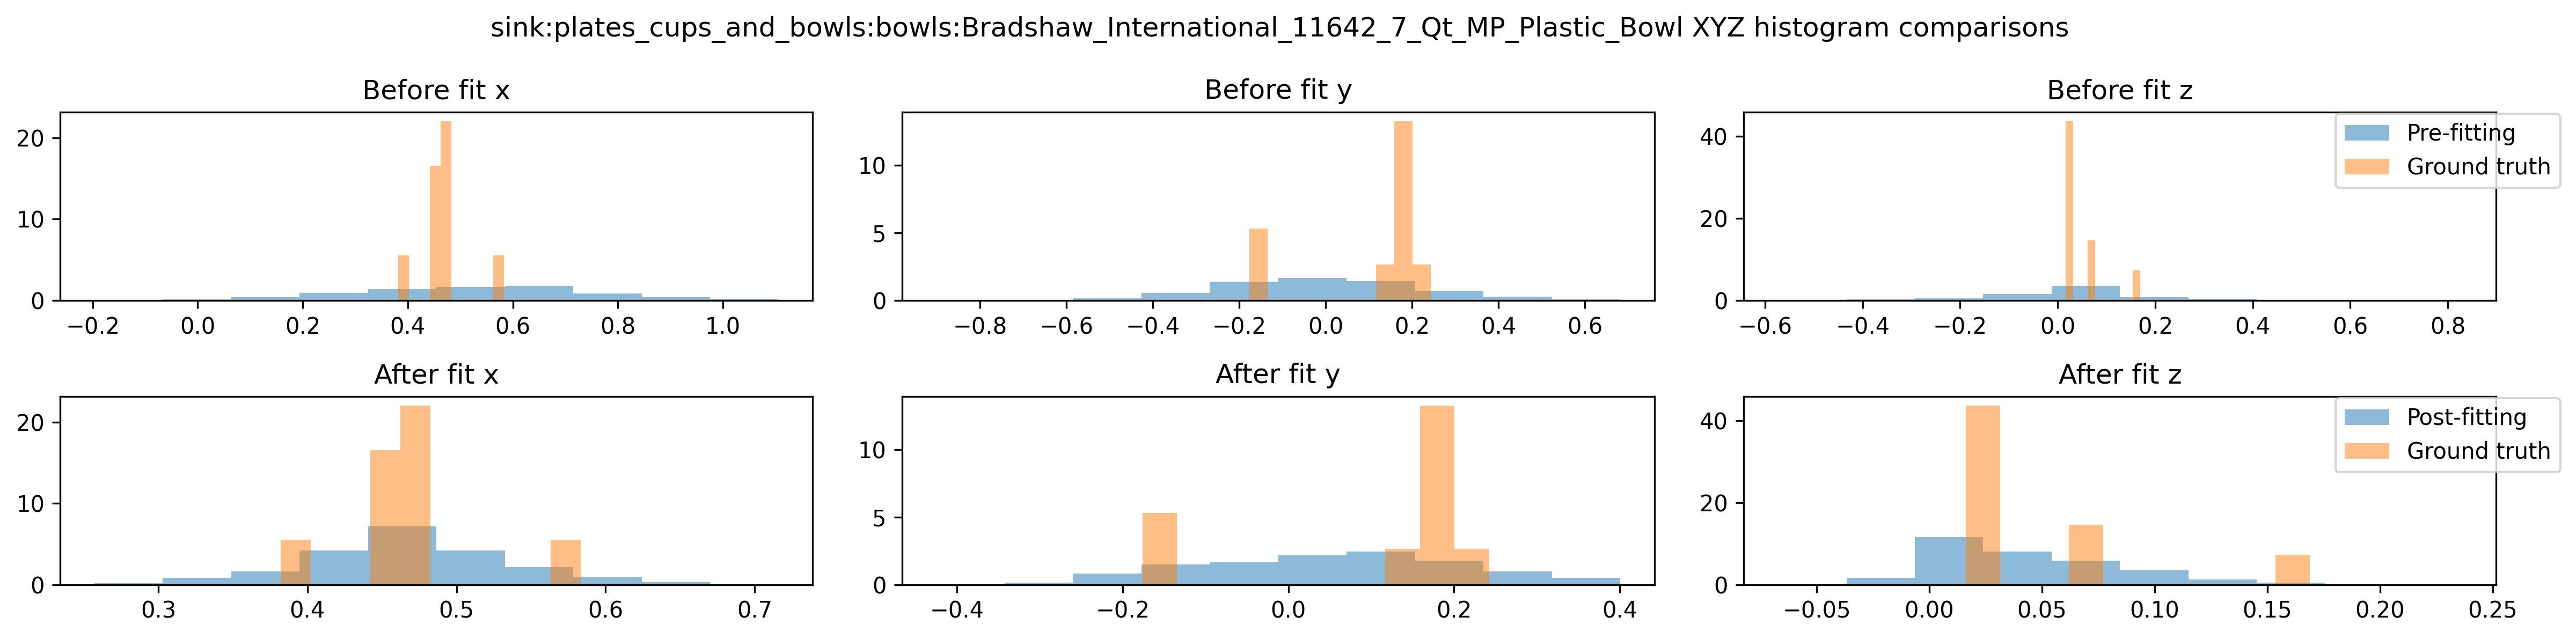

In [13]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [14]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)

# Test parsing a scene

In [15]:
# Set up grammar
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
grammar.load_state_dict(torch.load("fit_grammar.torch"))

<All keys matched successfully>

In [16]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
results = infer_mle_tree_with_mip(grammar, observed_node_sets[0], N_solutions=5, max_recursion_depth=10, verbose=True)
trees = get_optimized_trees_from_mip_results(results)
vis["parses"].delete()
for k, tree in enumerate(trees):
    if k == 0:
        draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k)
    print("Computed score %f, optimization score %f" % (tree.score(verbose=0), results.optim_result.get_suboptimal_objective(k)))

Starting setup.
Activation vars allocated.
Continuous variables allocated.
Setup time:  0.44796323776245117
Num vars:  3015
Num constraints:  6479
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Sep 30 20:05:13 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 4322 rows, 3015 columns and 18130 nonzeros
Model fingerprint: 0xd752953b
Model has 213 quadratic objective terms
Variable types: 2754 continuous, 261 integer (261 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+04]
  Objective range  [4e-01, 3e+04]
  QObjective range [3e+01, 2e+06]
  Bounds range     [1e-01, 1e+00]
  RHS range        [2e-16, 1e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3449 rows and 2321 columns
Presolve time: 0.03s
Presolved: 873 rows, 694 columns, 3826 nonzeros
Presolved model has 132 quadratic objective terms
Variable types: 679 continuous, 1

sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado_1267 (active 0.000000): child set score 0.000000
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise_1510 (active 0.000000): child set score 0.000000
sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise_765 (active 0.000000): child set score 0.000000
sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring_1170 (active 0.000000): child set score 0.000000
sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado_1268 (active 0.000000): child set score 0.000000
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise_1511 (active 0.000000): child set score 0.000000
sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise_766 (active 0.000000): child set score 0.000000
sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue_1084 (active 0.000000): child set score 0.000000
sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow_

Rot:  0.0
Bowl_3354:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue_1198 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3354:sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose_1086 (active 0.0): child 0.000000
Cup_3166 (active 0.000000): child set score -inf
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Cup_3166:sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue_1095 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.0000,  0.0000,  0.

child tf:  tensor([[-0.9309,  0.3651, -0.0118,  0.4246],
        [-0.3650, -0.9310, -0.0093, -0.2027],
        [-0.0144, -0.0043,  0.9999,  0.0153],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  -16.96838886409151
Rot:  3.8237630923461037
PlateStack_1083:Plate_4556 (active 1.0): child -13.144626
child tf:  tensor([[ 0.8121, -0.5783, -0.0776,  0.4422],
        [ 0.5827,  0.8107,  0.0567, -0.2168],
        [ 0.0301, -0.0912,  0.9954,  0.0352],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  -19.18593084108662
Rot:  1.654197358561507
PlateStack_1083:Plate_4557 (active 1.0): child -17.531733
PlateStack_1084 (active 0.000000): child set score -inf
child tf:  tensor([[-1.1879,  1.0246, -0.6616,  0.4834],
        [ 0.6019,  1.0690,  0.9526,  0.0218],
        [ 0.5191, -0.2485,  1.0001,  0.0147],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  -18.249325087850202
Rot:  -560.2726260416714
PlateStack_1084:Plate_4558 (active 0.0): child -578.521951
child tf:  tensor([[-1.1879,  1

Bowl_3353 (active 0.000000): child set score -inf
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3353:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_1181 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3353:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue_1197 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3353:sink:plates_cups_and_bowls:bowls:Room_Essentials_

child tf:  tensor([[-1.7132, -1.4133, -1.7132,  0.5833],
        [ 0.2518,  0.4517,  0.2518,  0.0366],
        [ 0.0389,  0.3130,  0.0389,  0.0717],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3342:sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose_1074 (active 0.0): child 0.000000
Bowl_3343 (active 0.000000): child set score -inf
child tf:  tensor([[-1.7132, -1.4133, -1.7132,  0.5833],
        [ 0.2518,  0.4517,  0.2518,  0.0366],
        [ 0.0389,  0.3130,  0.0389,  0.0717],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3343:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_1171 (active 0.0): child 0.000000
child tf:  tensor([[-1.7132, -1.4133, -1.7132,  0.5833],
        [ 0.2518,  0.4517,  0.2518,  0.0366],
        [ 0.0389,  0.3130,  0.0389,  0.0717],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3343:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Sciro

Plate_4563:sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise_774 (active 0.0): child 0.000000
Bowl_3352 (active 0.000000): child set score -inf
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3352:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_1180 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3352:sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue_1196 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.6616,  0.4634],
        [ 1.2488,  1.0690,  0.9526,  0.0549],
        [-0.2770,  1.2601,  1.0002,  0.0399],
        [ 0.00

Cup_3160 (active 0.000000): child set score -inf
child tf:  tensor([[-1.7132, -1.0052, -0.9997,  0.5268],
        [ 0.2518, -1.0308, -1.1166,  0.0452],
        [ 0.0389,  0.2721,  0.2560,  0.0846],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Cup_3160:sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue_1089 (active 0.0): child 0.000000
child tf:  tensor([[-1.7132, -1.0052, -0.9997,  0.5268],
        [ 0.2518, -1.0308, -1.1166,  0.0452],
        [ 0.0389,  0.2721,  0.2560,  0.0846],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Cup_3160:sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow_1029 (active 0.0): child 0.000000
child tf:  tensor([[-1.7132, -1.0052, -0.9997,  0.5268],
        [ 0.2518, -1.0308, -1.1166,  0.0452],
        [ 0.0389,  0.2721,  0.2560,  0.0846],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Cup_3160:sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_Whi

XYZ:  0.0
Rot:  0.0
Plate_4562:sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise_1518 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5833],
        [ 1.2488,  1.0690,  1.1934,  0.1677],
        [-0.2770,  1.2601,  1.0002,  0.1888],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_4562:sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise_773 (active 0.0): child 0.000000
Bowl_3351 (active 0.000000): child set score -inf
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5833],
        [ 1.2488,  1.0690,  1.1934,  0.1677],
        [-0.2770,  1.2601,  1.0002,  0.1888],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Bowl_3351:sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl_1179 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5833],
        [ 1.2488,  1.0690,  1.1934,  0.1677],
        [-0.2770,  1.2601,  1.0002,  0.

Cup_3155:sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White_1135 (active 0.0): child 0.000000
Cup_3156 (active 0.000000): child set score -inf
child tf:  tensor([[-1.7132, -1.0052, -0.9997,  0.5268],
        [ 0.2518, -1.0308, -1.1166,  0.0452],
        [ 0.0389,  0.2721,  0.2560,  0.0846],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Cup_3156:sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue_1085 (active 0.0): child 0.000000
child tf:  tensor([[-1.7132, -1.0052, -0.9997,  0.5268],
        [ 0.2518, -1.0308, -1.1166,  0.0452],
        [ 0.0389,  0.2721,  0.2560,  0.0846],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Cup_3156:sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow_1025 (active 0.0): child 0.000000
child tf:  tensor([[-1.7132, -1.0052, -0.9997,  0.5268],
        [ 0.2518, -1.0308, -1.1166,  0.0452],
        [ 0.0389,  0.2721,  0.2560,  0.0846],
        [ 0.0000,  0.0000,  0.

XYZ:  0.0
Rot:  0.0
Cup_3161:sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White_1141 (active 1.0): child 0.000000
Plate_4561 (active 0.000000): child set score -inf
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5833],
        [ 1.2488,  1.0690,  1.1934,  0.1677],
        [-0.2770,  1.2601,  1.0002,  0.1888],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_4561:sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring_1176 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5833],
        [ 1.2488,  1.0690,  1.1934,  0.1677],
        [-0.2770,  1.2601,  1.0002,  0.1888],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
XYZ:  0.0
Rot:  0.0
Plate_4561:sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado_1274 (active 0.0): child 0.000000
child tf:  tensor([[ 0.9308, -0.3544, -0.1997,  0.5833],
        [ 1.2488,  1.0690,  1.1934,  0.1677],
        [-0.2770,  1.2601,  1.0002, 

Computed score 16.282989, optimization score -489.926453
Computed score 16.282989, optimization score -489.926453
Computed score -9.701011, optimization score -485.416590
Computed score -930.350877, optimization score 459.989047
Computed score -930.350877, optimization score 459.989047
